In [ ]:
!pip install torchextractor

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import sys
import numpy as np
import pickle as pkl
from os.path import join as oj
from datetime import datetime
import torch.optim as optim
import os
from torch.utils.data import TensorDataset, ConcatDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import argparse
from PIL import Image
from tqdm import tqdm
from torch import nn
from numpy.random import randint
import torchvision.models as models
import time
import copy
import gc
import json
import pandas as pd
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
dir_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird"
#dir_path = "/content/drive/MyDrive/Projects/ISIC_224"

Mounted at /content/drive


In [ ]:
'''
import os
from PIL import Image

def resize_image(image_path, size=(224, 224)):
    """
    Resize the image to the specified size.

    Args:
    image_path (str): The path to the image to resize.
    size (tuple): The desired size to resize the image to.

    Returns:
    Image: The resized image.
    """
    with Image.open(image_path) as img:
        resized_img = img.resize(size, Image.ANTIALIAS)
        return resized_img

def process_directory(root_dir):
    """
    Traverse all subdirectories in the given directory and resize all images to 224x224.

    Args:
    root_dir (str): The root directory to start processing.
    """
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png',)):
                file_path = os.path.join(subdir, file)
                try:
                    resized_img = resize_image(file_path)
                    resized_img.save(file_path)
                    print(f"Resized and saved {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

root_dir = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird"

# Process the directory
process_directory(root_dir)
'''

<ipython-input-15-46d61f15cb43>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize(size, Image.ANTIALIAS)


Streaming output truncated to the last 5000 lines.
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Louisiana_Waterthrush_0082_177596.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0078_796649.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0054_796623.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0041_177630.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0057_177784.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0075_796678.jpg
Resized and saved /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/no_waterbirds_nopatch_224/Bohemian_Waxwing_0024_177661.jpg
Resized and saved /c

In [ ]:
model_path = oj(dir_path, "models", "initial_classifier")
model_training_path = oj(model_path, "training_224")
data_path = oj(dir_path, "data")

not_waterbird_path = oj(data_path, "processed", "no_waterbird_224")
waterbird_path = oj(data_path, "processed", "waterbird_224")

In [ ]:
import numpy as np
import argparse
import torch
import torchvision.models as models
import torch.nn as nn

mean = np.asarray([0.485, 0.456, 0.406])
std = np.asarray([0.229, 0.224, 0.225])

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(args.seed)
model = models.vgg16(pretrained=True)
#changing nn.Linear(4096, 1000) to nn.Linear(4096, 2) as vgg was trained on imagenet with 1000 classes originally
model.classifier[-1] = nn.Linear(4096, 2)
model = model.to(device)
params_to_update = model.classifier.parameters()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


In [ ]:
def clean_up_empty_files(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        if os.path.getsize(oj(path, list_files[i])) < 100:
            os.remove(oj(path, list_files[i]))
            print("File " + str(i) + "deleted!")
'''
def clean_up_duplicates(path1, path2):
    newfiles = os.listdir(path1)
    oldfiles = os.listdir(path2)
    diff = [f for f in newfiles if f not in oldfiles]
    for i in tqdm(diff):
        os.remove(oj(path1, i))
        print("File " + str(i) + "deleted!")

def check_img_sizes(path):
    list_files= os.listdir(path)
    num_files = len(list_files)
    for i in tqdm(range(num_files)):
        im = Image.open(oj(path, list_files[i]))
        if im.width != 224 or im.height != 224:
            print(list_files[i])
'''
# clean_up_empty_files(cancer_path)
# clean_up_empty_files(not_cancer_path)

# newpath = oj(data_path, "no_cancer_224_inpainted")
# oldpath = oj(data_path, "processed", "no_cancer_224")
# clean_up_duplicates(newpath, oldpath)

# check_img_sizes(not_cancer_path)


'\ndef clean_up_duplicates(path1, path2):\n    newfiles = os.listdir(path1)\n    oldfiles = os.listdir(path2)\n    diff = [f for f in newfiles if f not in oldfiles]\n    for i in tqdm(diff):\n        os.remove(oj(path1, i))\n        print("File " + str(i) + "deleted!")\n\ndef check_img_sizes(path):\n    list_files= os.listdir(path)\n    num_files = len(list_files)\n    for i in tqdm(range(num_files)):\n        im = Image.open(oj(path, list_files[i]))\n        if im.width != 224 or im.height != 224:\n            print(list_files[i])\n'

In [ ]:
class WaterbirdDataset(torch.utils.data.Dataset):
    def __init__(self, path: str = None, is_waterbird: int = None, data_files = None, labels = None):
        """
        Expects path and is_waterbird both to be supplied if the relevant images all lie in the same directory and have the same class
        or a list of full filepaths and list of all labels are both supplied using data_files and labels otherwise.
        """

        """
        Initializes the WaterbirdDataset.

        If 'path' and 'is_waterbird' are provided, it assumes that all images in the directory specified
        by 'path' belong to the same class 'is_waterbird'.

        Alternatively, if 'data_files' and 'labels' are provided, it uses these lists directly
        for file paths and corresponding labels.

        Args:
            path (str): Directory containing images, all belonging to the same class.
            is_waterbird (int): The class label (e.g., 1 for waterbird, 0 for non-waterbird) for all images in the directory.
            data_files (list): List of full file paths to images.
            labels (list): List of labels corresponding to 'data_files'.
        """
        if path: # If a path is provided, list all files in the directory and assign the class label
            self.path = path
            self.data_files = os.listdir(self.path)
            self.is_waterbird = is_waterbird

        else: # Otherwise, use provided lists of data files and labels
            self.path = ''
            self.data_files = data_files
            self.labels = labels
            self.is_waterbird = None

    def __getitem__(self, i):

        """
        Retrieves an image and its label at index 'i'.

        Args:
            i (int): Index of the image to retrieve.

        Returns:
            tuple: (image tensor, label)
        """


        # Read in the image, convert to float between [0,1] and standardise , and convert to a PyTorch tensor
        img = Image.open(oj(self.path, self.data_files[i]))
        img_array = np.asarray(img)/255.0 # Convert image to float and scale to [0, 1]
        img_array -= mean[None, None, :] # Subtract the mean for normalization
        img_array /= std[None, None, :] # Divide by the standard deviation for normalization
        img.close()
        torch_img = torch.from_numpy(img_array.swapaxes(0,2).swapaxes(1,2)).float() # Convert the numpy array to a PyTorch tensor and rearrange the axes
        # Determine the label: use the global class label if provided, otherwise extract the relevant label from the list of labels.
        is_waterbird = self.is_waterbird if self.is_waterbird is not None else self.labels[i]
        return (torch_img, is_waterbird)

    def __len__(self): # Returns the total number of images in the dataset.
        return len(self.data_files)

## Functions for Training

In [ ]:
def gradient_sum(im, target, model, crit, device='cuda'):
    '''assume that eveything is already on cuda'''
    im.requires_grad = True # Enable gradient computation for the input image
    grad_params = torch.abs(torch.autograd.grad(crit(model(im), target), im,create_graph = True)[0].sum(dim=1)).sum()
    return grad_params

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, resume_training=False):
    since = time.time()
    # train_loss_history = []
    # train_acc_history = []
    # train_cd_history= []


    # Initialize best_loss, patience, and cur_patience to manage early stopping.
    best_loss = 10.0
    patience = 3 # Number of epochs to wait for improvement
    cur_patience = 0 # Current patience counter

    if len(os.listdir(model_training_path)) > 0 and resume_training:
      # Check if there are saved model files and resume training if needed
        model_list = [(f, os.path.getmtime(oj(model_training_path,f))) for f in os.listdir(model_training_path) if f.endswith('.pt')]
        model_list.sort(key=lambda tup: tup[1], reverse=True)  # Sort models by modification time in place from most to least recent
        model_name = model_list[0][0]
        model.classifier.load_state_dict(torch.load(oj(model_training_path, model_name)))
        print("Model loaded!")

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        optimizer.step() # Update the model parameters
        model.train()  # Set model to training mode
        phase = 'train'
        running_loss = 0.0
        running_loss_cd = 0.0
        running_corrects = 0

        # Iterate over data , moving inputs and labels to the specified device.
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                # need to do calc beforehand because we do need the gradients
                if phase == 'train' and regularizer_rate !=0:
                  # Apply gradient regularization if specified , compute additional loss from gradients and update the model.
                    inputs.requires_grad = True
                    add_loss = gradient_sum(inputs, labels, model, criterion)
                    if add_loss!=0:
                        (regularizer_rate*add_loss).backward()
                        optimizer.step()
                    #print(torch.cuda.memory_allocated()/(np.power(10,9)))
                    optimizer.zero_grad()
                    running_loss_cd += add_loss.item() * inputs.size(0)

                    #inputs.require_grad = False

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    (loss).backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_cd_loss = running_loss_cd / dataset_sizes[phase]

        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f} CD Loss : {:.4f}'.format(
            phase, epoch_loss, epoch_acc, epoch_cd_loss))

        # train_loss_history.append(epoch_loss)
        # train_cd_history.append(epoch_cd_loss)
        # train_acc_history.append(epoch_acc.item())
        torch.save(model.classifier.state_dict(), oj(model_training_path, datetime.now().strftime("%Y%m%d%H%M%S") + ".pt"))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)
    )
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    return model

## Functions for Evaluation

In [ ]:
from sklearn.metrics import auc,average_precision_score, roc_curve,roc_auc_score,precision_recall_curve, f1_score

def get_output(model, dataset):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                             shuffle=False, num_workers=2)
    model = model.eval()
    y = []
    y_hat = []
    softmax= torch.nn.Softmax() #Creates a Softmax function to convert logits to probabilities.
    with torch.no_grad() : # Disables gradient computation for the operations within this block, saving memory and computation.

        # Iterate over the DataLoader, moves inputs to GPU, and appends true labels and predicted probabilities to their respective lists.
        for inputs, labels in data_loader:
            y_hat.append((labels).cpu().numpy())
            y.append(torch.nn.Softmax(dim=1)( model(inputs.cuda()))[:,1].detach().cpu().numpy()) # take the probability for waterbird
    y_hat = np.concatenate( y_hat, axis=0 )
    y = np.concatenate( y, axis=0 )
    return y, y_hat # in the training set the values were switched

def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        # Load model weights from file
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        # Load weights into the model
        if "classifier.0.weight" in weights.keys(): #for the gradient models we unfortunately saved all of the weights
            model.load_state_dict(weights)
        # Get true labels and predictions from the whole model
        else:
            model.classifier.load_state_dict(weights)
        # Get true labels and predictions from the classifier part of the model
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

## Initial Classifier Training (on waterbirds no patch and not waterbirds with & without patch)

In [ ]:
waterbird_no_patch_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"

In [ ]:
waterbird_no_patch_dataset = WaterbirdDataset(path=waterbird_no_patch_path, is_waterbird=1)
not_waterbird_dataset = WaterbirdDataset(path=not_waterbird_path, is_waterbird=0)
complete_dataset = ConcatDataset((waterbird_no_patch_dataset, not_waterbird_dataset))

num_total = len(complete_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_dataset, test_dataset = torch.utils.data.random_split(complete_dataset, [num_train, num_test])
datasets = {'train' : train_dataset, 'test':test_dataset}
dataset_sizes = {'train' : len(train_dataset), 'test':len(test_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

num_train: 8758
num_test: 2190


In [ ]:
def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the waterbird_dataset and not_waterbird_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole waterbird dataset is stored in train_subset.dataset.datasets[0]
  waterbird_no_patch_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_waterbird_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = waterbird_no_patch_filepaths + not_waterbird_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files

In [ ]:
# Call the function and get the full file paths.
train_files, test_files = extract_filenames(train_dataset, test_dataset)
list_to_file(train_files, oj(dir_path, 'models', 'train_files.txt'))   # Write the training filepaths to a text file.
list_to_file(test_files,  oj(dir_path, 'models', 'test_files.txt'))    # Write the testing filepaths to a text file.

## Weights for Training

In [ ]:
waterbird_ratio = len(waterbird_no_patch_dataset)/len(complete_dataset)

not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1/waterbird_ratio
not_waterbird_weight = 1/ not_waterbird_ratio
weights = np.asarray([not_waterbird_weight, waterbird_weight])
weights /= weights.sum()
weights = torch.tensor(weights).to(device)

criterion = nn.CrossEntropyLoss(weight = weights.double().float())

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, resume_training=False)
pid = datetime.now().strftime('%Y%m%d%H%M%S')
torch.save(model.classifier.state_dict(),oj(dir_path, model_path, pid + ".pt"))

Epoch 1/10
----------


548it [16:49,  1.84s/it]


train Loss: 0.4895 Acc: 0.7724 CD Loss : 0.0000
Epoch 2/10
----------


548it [02:19,  3.94it/s]


train Loss: 0.3437 Acc: 0.8600 CD Loss : 0.0000
Epoch 3/10
----------


548it [02:18,  3.96it/s]


train Loss: 0.3052 Acc: 0.8744 CD Loss : 0.0000
Epoch 4/10
----------


548it [02:20,  3.91it/s]


train Loss: 0.2912 Acc: 0.8806 CD Loss : 0.0000
Epoch 5/10
----------


548it [02:21,  3.88it/s]


train Loss: 0.2762 Acc: 0.8866 CD Loss : 0.0000
Epoch 6/10
----------


548it [02:19,  3.94it/s]


train Loss: 0.2683 Acc: 0.8921 CD Loss : 0.0000
Epoch 7/10
----------


548it [02:22,  3.85it/s]


train Loss: 0.2543 Acc: 0.8955 CD Loss : 0.0000
Epoch 8/10
----------


548it [02:20,  3.90it/s]


train Loss: 0.2565 Acc: 0.8953 CD Loss : 0.0000
Epoch 9/10
----------


548it [02:20,  3.91it/s]


train Loss: 0.2537 Acc: 0.8944 CD Loss : 0.0000
Epoch 10/10
----------


548it [02:18,  3.96it/s]


train Loss: 0.2507 Acc: 0.8994 CD Loss : 0.0000
Training complete in 38m 24s
Best val loss: 10.000000


In [ ]:
auc, f1 = get_auc_f1(model, test_dataset)
print("AUC: ", auc)
print("F1: ", f1)

AUC:  0.9658619755471272
F1:  0.8147174770039421


In [ ]:
results_file_path = oj(dir_path, "auc_f1_224_waterbird_no_patch.txt")
print(results_file_path)
with open(results_file_path, 'w') as f:
    f.write('AUC: ' + str(auc) + "\n")
    f.write('F1: ' + str(f1) + "\n")

/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/auc_f1_224_waterbird_no_patch.txt


In [ ]:
stophere

NameError: name 'stophere' is not defined

## Reload the model to skip retrainig and test with waterbird patched images

In [ ]:
waterbird_patch_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224'
not_waterbird_path = '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/data/processed/no_waterbird_224'

In [ ]:
waterbird_patch_dataset = WaterbirdDataset(path=waterbird_patch_path, is_waterbird=1)
not_waterbird_dataset = WaterbirdDataset(path=not_waterbird_path, is_waterbird=0)
complete_patch_dataset = ConcatDataset((waterbird_patch_dataset, not_waterbird_dataset))

num_total = len(complete_patch_dataset)
num_train = int(0.8 * num_total)
num_test = num_total - num_train
torch.manual_seed(0);
print("num_train:", num_train)
print("num_test:", num_test)

train_patch_dataset, test_patch_dataset = torch.utils.data.random_split(complete_patch_dataset, [num_train, num_test])
datasets = {'train' : train_patch_dataset, 'test':test_patch_dataset}
dataset_sizes = {'train' : len(train_patch_dataset), 'test':len(test_patch_dataset)}

dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=args.batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}


num_train: 7972
num_test: 1993


In [ ]:

def list_to_file(li, filename):
  with open(filename, 'w') as f:
    for item in li:
      f.write("%s\n" % item)

def extract_filenames(train_subset, test_subset):
  # Extract the relevant indices of the concat dataset
  train_idx, test_idx = train_subset.indices, test_subset.indices

  # Extract the filenames for the waterbird_dataset and not_waterbird_dataset and concatenate with their directory path.
  # Each original dataset is stored by the ConcatDataset class. So even though train_subset is a subset, the info for the whole waterbird dataset is stored in train_subset.dataset.datasets[0]
  waterbird_filepaths      = [oj(train_subset.dataset.datasets[0].path, file) for file in train_subset.dataset.datasets[0].data_files]
  not_waterbird_filepaths  = [oj(train_subset.dataset.datasets[1].path, file) for file in train_subset.dataset.datasets[1].data_files]

  filepaths = waterbird_filepaths + not_waterbird_filepaths    # Append the lists together, this combined list is what the indices are based on.

  train_files = [filepaths[i] for i in train_idx]
  test_files  = [filepaths[i] for i in test_idx]

  return train_files, test_files


In [ ]:
def get_auc_f1(model, dataset,fname = None, ):
    if fname !=None:
        with open(fname, 'rb') as f:
            weights = torch.load(f)
        if "classifier.0.weight" in weights.keys(): #for the gradient models they saved all of the weights
            model.load_state_dict(weights)
        else:
            model.classifier.load_state_dict(weights)
        y, y_hat = get_output(model.classifier, dataset)
    else:
        y, y_hat = get_output(model, dataset)
    auc =roc_auc_score(y_hat, y)
    f1 = np.asarray([f1_score(y_hat, y > x) for x in np.linspace(0.1,1, num = 10) if (y >x).any() and (y<x).any()]).max()
    return auc, f1

In [ ]:
def save_predictions(model, dataset, filename):
    predictions = []
    true_labels = []

    # Iterate over the dataset
    for inputs, labels in dataset:
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        inputs = inputs.to(device)  # Move data to appropriate device
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Append predictions to the list
        predictions.append(predicted.item())

        # Check if labels are integers or tensors
        if isinstance(labels, torch.Tensor):
            true_labels.append(labels.item())
        else:
            true_labels.append(labels)  # Assume labels are integers

    # Create a DataFrame to store predictions and true labels
    df = pd.DataFrame({
        'Prediction': predictions,
        'True Label': true_labels
    })

    # Save DataFrame to CSV file
    df.to_csv(filename, index=False)
    print(f"Predictions saved to {filename}")

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 2)  # Modify classifier

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240531073132.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# waterbird_dataset and complete_dataset are already defined
waterbird_ratio = len(waterbird_patch_dataset) / len(complete_dataset)
not_waterbird_ratio = 1 - waterbird_ratio
waterbird_weight = 1 / waterbird_ratio
not_waterbird_weight = 1 / not_waterbird_ratio
weights = torch.tensor([not_waterbird_weight, waterbird_weight], device=device, dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight=weights)

# Define arguments
class Args:
    def __init__(self):
        self.batch_size = 16
        self.epochs = 10
        self.lr = 0.00001
        self.momentum = 0.9
        self.seed = 42
        self.regularizer_rate = 0.0

args = Args()

regularizer_rate = args.regularizer_rate
num_epochs = args.epochs

torch.manual_seed(args.seed)

params_to_update = model.classifier.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=args.lr, momentum=args.momentum)


In [ ]:
auc, f1 = get_auc_f1(model, test_patch_dataset)
print("AUC: ", auc)
print("F1: ", f1)

AUC:  0.8242933607632753
F1:  0.3814713896457766


In [ ]:
save_predictions(model, test_patch_dataset, '/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/patch_predictions.csv')

Predictions saved to /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/patch_predictions.csv


## Load model and extract activations from last layer

In [ ]:
# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240531073132.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    # Flatten the tensor before passing it to the linear layers
    image_tensor = model.features(image_tensor)
    image_tensor = model.avgpool(image_tensor)
    image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor

    # Pass the tensor through the first 5 layers
    for layer_idx, layer in enumerate(model.classifier[:5], start=1):
        image_tensor = layer(image_tensor)

    # Extract activations from the sixth linear layer
    activations = model.classifier[5](image_tensor)
    activations = activations.squeeze().cpu().detach().numpy()
    #print("Activation size:", activations.shape)

    return activations

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
    return all_activations

# Folder path containing images
patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
no_patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")

wp_waterbird_all_activations shape: (840, 4096)
wo_waterbird_all_activations shape: (1823, 4096)


In [ ]:
import os
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Modify the classifier
model.classifier[-1] = torch.nn.Linear(4096, 2)

# Load the saved parameters into the model
saved_model_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/models/initial_classifier/20240531073132.pt"
model.classifier.load_state_dict(torch.load(saved_model_path))

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_and_extract_activations(image_path):
    try:
        # Load and preprocess the image
        image = Image.open(image_path)
        print(f"Image loaded: {image_path}")  # Debug: Check if image is loaded
        # unsqueeze(0) adds an extra dimension to simulate a batch of size 1
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        print(f"Image preprocessed: {image_tensor.shape}")  # Debug: Check the tensor shape

        # Flatten the tensor before passing it to the linear layers
        image_tensor = model.features(image_tensor)
        print(f"Features extracted: {image_tensor.shape}")  # Debug: Check the tensor shape after features
        image_tensor = model.avgpool(image_tensor)
        image_tensor = torch.flatten(image_tensor, 1)  # Flatten the tensor
        print(f"Tensor flattened: {image_tensor.shape}")  # Debug: Check the flattened tensor shape

        # Sequentially pass the tensor through the first five layers of the classifier
        for layer_idx, layer in enumerate(model.classifier[:5], start=1):
            image_tensor = layer(image_tensor)
            print(f"Layer {layer_idx} output shape: {image_tensor.shape}")  # Debug: Check the output shape of each layer

        # Extract activations from the sixth linear layer of the classifier
        activations = model.classifier[5](image_tensor)
        activations = activations.squeeze().cpu().detach().numpy()
        print(f"Activations extracted: {activations.shape}")  # Debug: Check the activations shape
        return activations
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to recursively traverse folders and process images
def process_images_in_folder(folder_path):
    all_activations = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                print(f"Processing image: {image_path}")  # Debug: print the image path being processed
                activations = preprocess_and_extract_activations(image_path)
                if activations is not None:
                    all_activations.append(activations)
                else:
                    print(f"Failed to process image: {image_path}")  # Debug: print if image processing failed
    return all_activations

# Folder path containing images
patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
no_patch_waterbird_folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"

# Extract activations for all images in the folder
wp_waterbird_all_activations = process_images_in_folder(patch_waterbird_folder_path)
wo_waterbird_all_activations = process_images_in_folder(no_patch_waterbird_folder_path)

if wp_waterbird_all_activations:
    print("wp_waterbird_all_activations shape:", np.vstack(wp_waterbird_all_activations).shape)
else:
    print("No activations found in wp_waterbird_all_activations")

if wo_waterbird_all_activations:
    print("wo_waterbird_all_activations shape:", np.vstack(wo_waterbird_all_activations).shape)
else:
    print("No activations found in wo_waterbird_all_activations")


Streaming output truncated to the last 5000 lines.
Layer 3 output shape: torch.Size([1, 4096])
Layer 4 output shape: torch.Size([1, 4096])
Layer 5 output shape: torch.Size([1, 4096])
Activations extracted: (4096,)
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224/California_Gull_0100_41088.jpg
Image loaded: /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224/California_Gull_0100_41088.jpg
Image preprocessed: torch.Size([1, 3, 224, 224])
Features extracted: torch.Size([1, 512, 7, 7])
Tensor flattened: torch.Size([1, 25088])
Layer 1 output shape: torch.Size([1, 4096])
Layer 2 output shape: torch.Size([1, 4096])
Layer 3 output shape: torch.Size([1, 4096])
Layer 4 output shape: torch.Size([1, 4096])
Layer 5 output shape: torch.Size([1, 4096])
Activations extracted: (4096,)
Processing image: /content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224/California_Gull_0067_40973.jpg
Image loaded: /conten

In [ ]:
# each row corresponds to the activations of one image.
#np.vstack(wp_waterbird_all_activations).shape

In [ ]:
# Save activations for malignant wit patches as npy array (Sari likes npy, I like csv)
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy',np.vstack(wp_waterbird_all_activations))
np.save('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy',np.vstack(wo_waterbird_all_activations))

In [ ]:
'''
import shutil
folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"
files= os.listdir(folder_path)
# Creates a dataset of waterbirds images without patches for further analysis
for imgname in files:
    shutil.copyfile('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/data/processed/waterbird_224/'+imgname,'/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_nopatch_224/'+imgname)
'''

In [ ]:
#folder_path = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
folder_path_waterbird_patch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_patch_224"
folder_path_waterbird_nopatch = "/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbirds_nopatch_224"


files_patch= os.listdir(folder_path_waterbird_patch)
files_nopatch= os.listdir(folder_path_waterbird_nopatch)


num_waterbird_patch_test = len(files_patch)
num_waterbird_nopatch_test = len(files_nopatch)


patch_no_patch = np.hstack([np.zeros((1,num_waterbird_nopatch_test)),np.ones((1,num_waterbird_patch_test))])

wp = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wp_activations.npy')
wo = np.load('/content/drive/MyDrive/Masterthesis/Datasets/Waterbird/waterbird_test_wo_activations.npy')
wop_activations = np.vstack([wo,wp])

In [ ]:
wop_activations.shape

(2663, 4096)

In [ ]:
two_arrays = np.concatenate((patch_no_patch.T, wop_activations), axis=1) # 900x568
corr = np.corrcoef(two_arrays.T)

In [ ]:
patch_no_patch.shape

(1, 2663)

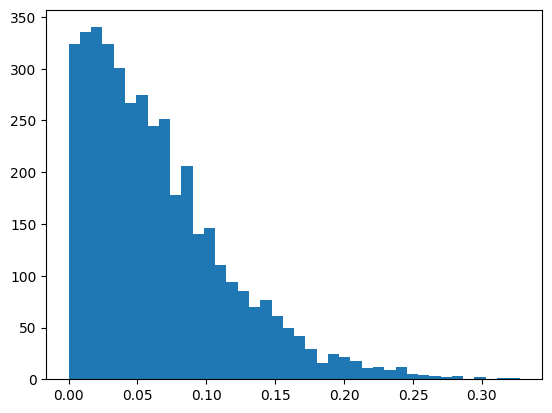

In [ ]:
import matplotlib.pyplot as plt
activations_corr = np.abs(corr[0][1:])
_ = plt.hist(activations_corr, bins='auto')

In [ ]:
activations_corr.shape

(4096,)

In [ ]:
print(activations_corr)

[0.09386765 0.13238387 0.08608127 ... 0.03367244 0.02950873 0.04412722]
